# Bechdel Data Analysis

The Bechdel Test, or Bechdel-Wallace Test, sometimes called the Mo Movie Measure or Bechdel Rule is a simple test 
 which names the following three criteria: 
 (1) it has to have at least two women in it, who 
 (2) who talk to each other, about 
 (3) something besides a man.

In this Analysis, we will start by seeing how the Bechdel Test has evolved during the years and its results in different world regions.

We will then try to see how it relates to other factors of movies such as revenue, rating and the number of female lead acotrs per film.

In [51]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
import json
import math
from statsmodels.stats import diagnostic
from scipy import stats
from numpy.polynomial.polynomial import Polynomial

#### Getting the Bechdel test database and the Movie database

The code below is used to get the Bechdel test results from the API and store that in a DataFrame

In [4]:

url = 'http://bechdeltest.com/api/v1/getAllMovies'

response = requests.get(url)

if response.status_code == 200:
    print('Request was succesful')
    movie_data = response.json()
    df_bechdel = pd.DataFrame(movie_data)
    print(df_bechdel.sample())

else:
    print('Request failed')

Request was succesful
        id  year                                        title   imdbid  rating
2733  7426  1990  Dragon Ball Z: Bardock - The Father of Goku  0142245       0


In [5]:
df_bechdel.sample(10)

,id,year,title,imdbid,rating
9128,8239,2018,Tully,5610554,3
1582,2391,1972,Avanti!,0068240,3
1787,3190,1976,In the Realm of the Senses,0074102,3
2442,2665,1987,High Tide,0095305,3
1325,10477,1966,"Silencers, The",0060980,1
3198,1065,1995,Aladdin and the King of Thieves,0115491,1
8707,7775,2016,Martyrs,1663655,3
2849,10871,1991,Backdraft,0101393,1
4453,2262,2003,In the Cut,0199626,3
7265,6658,2012,Alien Tornado,1942798,3


In [6]:
data_folder = './MovieSummaries/'

column_names= ['wikipedia_movie_id', 'freebase_id','title','release_date','revenue','runtime','language','countries','genre']

df_movies=pd.read_csv(data_folder + 'movie.metadata.tsv', sep = '\t', names=column_names)
df_movies.head(10)


,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,/m/06_y2j7,Contigo y aquí,1974,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,/m/075f66,City of the Dead,1960,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [7]:
column_names = ['movie_freebase_id', 'release_date','character_name','birth','gender','character_height', 'actor_ethnicity',
                'actor_name','actor_age', 'actor_gender_freebase_id','character_freebase_id','freebase_character_map']

df_characters=pd.read_csv(data_folder+'/character.metadata.tsv', sep= '\t', names = column_names)

df_characters.index.name='wikipedia_movie_id'

df_characters.sample(8)

,movie_freebase_id,release_date,character_name,birth,gender,character_height,actor_ethnicity,actor_name,actor_age,actor_gender_freebase_id,character_freebase_id,freebase_character_map
wikipedia_movie_id,,,,,,,,,,,,
3140828,/m/08v03f,2007-02-08,Allison,1971-11-22,F,NaN,NaN,Cecilia Suárez,35.0,/m/02_4k_g,/m/0h6f2y7,/m/0b7lmw
24034499,/m/07k9clv,1942-02-20,Peewee,1921-02-06,M,NaN,NaN,David Gorcey,21.0,/m/0n5qgqj,/m/0kvr_5p,/m/0260wtf
25451837,/m/09k69t_,1989-03-23,Radha,1965-10-03,F,NaN,/m/0dryh9k,Radha,23.0,/m/0gbnb4k,/m/0h81nbl,/m/0c18ht
24549683,/m/080n24g,2004-12-23,NaN,1980-12-17,M,1.72,NaN,Indrajith,24.0,/m/08d0g3g,NaN,/m/0gvbc_
33301923,/m/0cr6fnk,1962,Radha,1936-05-14,F,1.55,/m/04y29,Waheeda Rehman,25.0,/m/0cr7q33,/m/0cr7q1r,/m/07f0tw
3139727,/m/08tz29,1935,NaN,1864-11-19,M,NaN,NaN,George Barbier,NaN,/m/0cs3jjz,NaN,/m/080k1hc
11467488,/m/02rdvz1,2007-09-28,Agatha Smith,1972-11-16,F,1.80,NaN,Missi Pyle,34.0,/m/0c0ly31,/m/0c0ly6t,/m/077qsp
22360971,/m/05sxt6y,1970-05,Metello,1951-05-03,M,NaN,NaN,Massimo Ranieri,NaN,/m/05tg17s,/m/0m_21xg,/m/01m8g__


#### Bechdel test results along the years

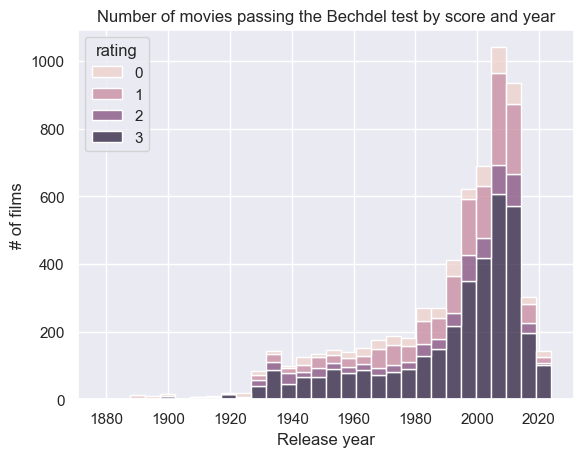

In [20]:
#we here want to plot the number of movies passing the Bechdel test by year


df_mb = pd.merge(df_movies, df_bechdel, how= 'inner')


sns.histplot(data=df_mb, x='year', hue='rating',multiple='stack',bins=30)

plt.title('Number of movies passing the Bechdel test by score and year')
plt.xlabel('Release year')
plt.ylabel('# of films');



We can see how the number of films passing the Bechdel test has increased along the years. 

Nevertheless, we are not sure whether the proportion of films that pass the test has actually gone up. This is why we are now going to graph the average bechdel test result by year.

Pearson correlation: 0.5726, p-value: 3.011166257060135e-12


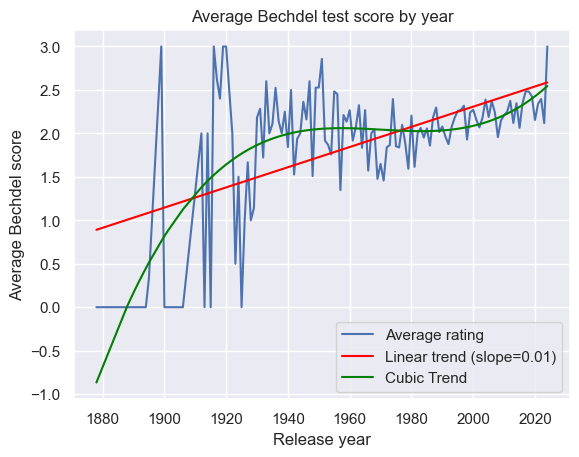

In [63]:
df_year_bechdel = df_mb.groupby('year')['rating'].agg('mean').reset_index()
df_year_bechdel = df_year_bechdel.rename(columns={'rating':'avg_bechdel_score'})

p = Polynomial.fit(df_year_bechdel['year'], df_year_bechdel['avg_bechdel_score'], deg=3)
df_year_bechdel['poly_fit'] = p(df_year_bechdel['year'])

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel['year'],df_year_bechdel['avg_bechdel_score'])


sns.lineplot(data=df_year_bechdel, x='year', y='avg_bechdel_score', label='Average rating')
plt.plot(df_year_bechdel['year'], slope*df_year_bechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.2f})')
sns.lineplot(data=df_year_bechdel, x='year', y='poly_fit', label='Cubic Trend', color='green')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

correlation, p_value = stats.pearsonr(df_year_bechdel['year'], df_year_bechdel['avg_bechdel_score'])
print(f"Pearson correlation: {correlation:.4f}, p-value: {p_value}")


By these results, we can observe that the Bechdel test results definitely go up as the years go by. This can be interpreted from our positive slope and our negative intercept in the linear regression. Nevertheless our rvalue tells us that only around half of this increment is due to time passing by, and we should identify other impactful factors.

Lastly, the Pearson regression shows that these two variables are related to around 0.57, which is a medium correlation, and this relation is very probably not due to randomness, since we have a very small p-value.

#### Bechdel test results in different World Regions

To determine how the Bechdel test results have evolved in different world regions, we decided to do a continent partition. This was decided to avoid complicated geopolitical definitions. And by using the pycountry_convert library, we can easily do a conversion between the countries and the continent.

In [66]:
df_mb['countries'].value_counts()

def get_continent(country_list):
    try:
        country_dict=json.loads(country_list)

        if not country_dict:
            return None

        country_name = list(country_dict.values())[0] #I might need to have different continents! Here I only have the first one!
        country_alpha2=pc.country_name_to_country_alpha2(country_name)
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except KeyError or IndexError:
        return None

df_mb['continent']=df_mb['countries'].apply(get_continent)

df_mb['continent'].value_counts()

continent
NA    4336
EU    1153
AS     419
OC      92
SA      18
AF       8
Name: count, dtype: int64

We can see a clear underrepresentation in films that are neither Northamerican nor european in the bechdel test results. This will completely invalidate the results found for South America and Africa

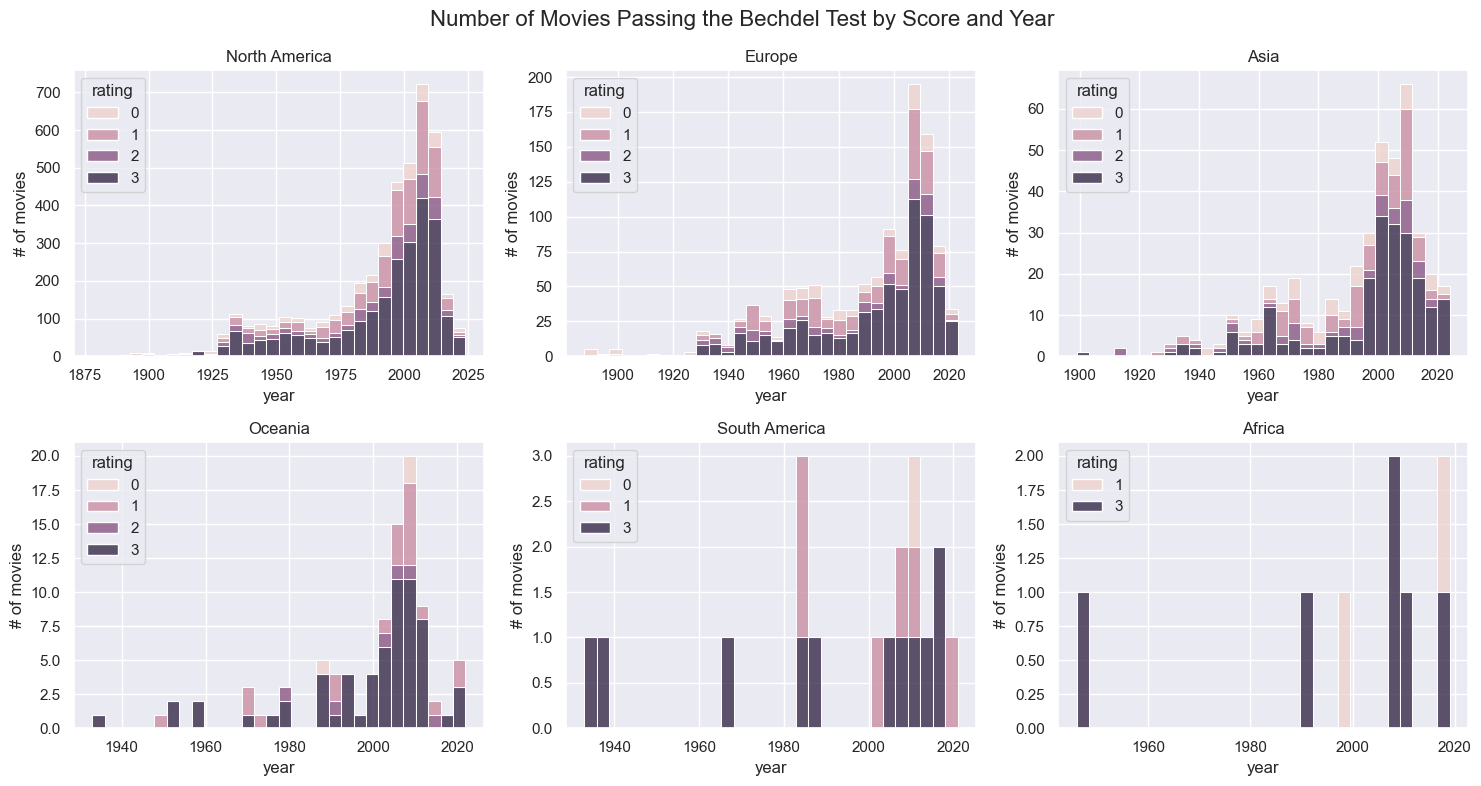

In [67]:
#by region now

sns.set()

fig, axes = plt.subplots(2,3, figsize = (15,8))

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.histplot(data=df_mb[df_mb['continent'] == 'NA'], x='year', hue='rating', multiple='stack', bins=30, ax=axes[0,0]).set(title='North America', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_mb[df_mb['continent'] == 'EU'], x='year', hue='rating', multiple='stack', bins=30, ax=axes[0,1]).set(title='Europe', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_mb[df_mb['continent'] == 'AS'], x='year', hue='rating', multiple='stack', bins=30, ax=axes[0,2]).set(title='Asia', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_mb[df_mb['continent'] == 'OC'], x='year', hue='rating', multiple='stack', bins=30, ax=axes[1,0]).set(title='Oceania', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_mb[df_mb['continent'] == 'SA'], x='year', hue='rating', multiple='stack', bins=30, ax=axes[1,1]).set(title='South America', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_mb[df_mb['continent'] == 'AF'], x='year', hue='rating', multiple='stack', bins=30, ax=axes[1,2]).set(title='Africa', 
                                                                                                                          ylabel = '# of movies')

plt.tight_layout(rect=[0, 0, 1, 1]);


As guessed, the graphs for South America and Africa don't look representative at all.

Like we did above, we are going to do the averages by continent

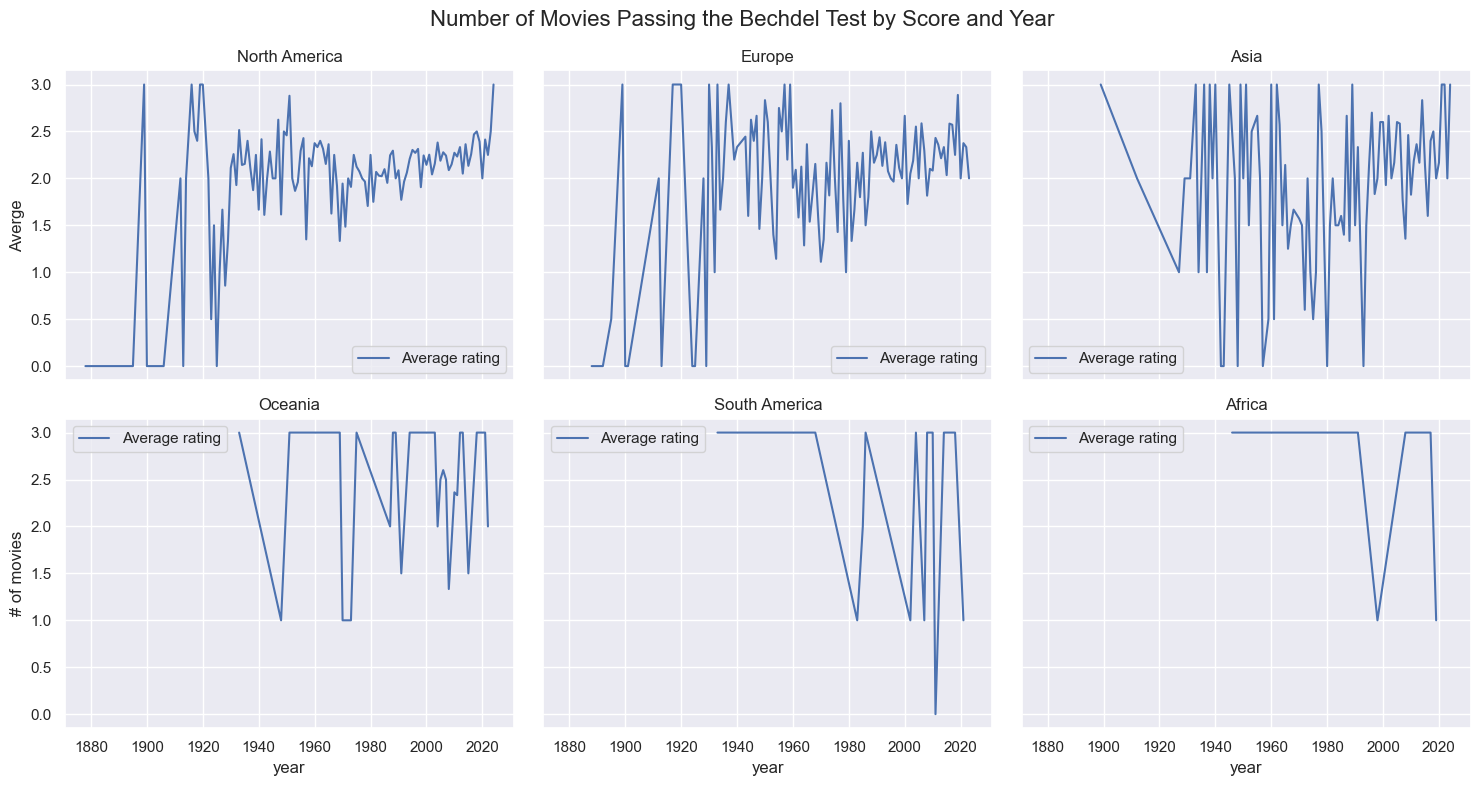

In [72]:
# Step 1: Create a pivot table with average Bechdel score per year per continent
df_avg_continent = df_mb.pivot_table(
    index='year', 
    columns='continent', 
    values='rating', 
    aggfunc='mean'
).reset_index()

# Step 2: Rename columns to make it more descriptive
df_avg_continent.columns = ['year'] + [f'avg_bechdel_score_{col}' for col in df_avg_continent.columns[1:]]

sns.set()

fig, axes = plt.subplots(2,3, figsize = (15,8), sharex=True, sharey = True)

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_NA', label = 'Average rating',ax=axes[0,0]).set(title='North America',
                                                                                                                  ylabel = 'Averge')
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_EU', label = 'Average rating',ax=axes[0,1]).set(title='Europe',
                                                                                                                  ylabel = '# of movies')
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_AS', label = 'Average rating',ax=axes[0,2]).set(title='Asia',
                                                                                                                  ylabel = '# of movies')
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_OC', label = 'Average rating',ax=axes[1,0]).set(title='Oceania',
                                                                                                                  ylabel = '# of movies')
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_SA', label = 'Average rating',ax=axes[1,1]).set(title='South America',
                                                                                                                  ylabel = '# of movies')
sns.lineplot(data=df_avg_continent, x='year', y='avg_bechdel_score_AF', label = 'Average rating',ax=axes[1,2]).set(title='Africa',
                                                                                                                  ylabel = '# of movies')

plt.tight_layout(rect=[0, 0, 1, 1]);


#### Connection between the number of lead female actresses and the Bechdel test score

In [11]:
female_counts = df_characters[df_characters['gender'] == 'F'].groupby('wikipedia_movie_id').size().reset_index(name='nbr_female_actors')

# Merge the counts into df_mb, ensuring all rows from df_mb are retained (left join)
df_mb = df_mb.merge(female_counts, on='wikipedia_movie_id', how='left')


df_mb.sample(15)

,wikipedia_movie_id,freebase_id,title,release_date,revenue,runtime,language,countries,genre,id,year,imdbid,rating,continent,nbr_female_actors
1469,1223479,/m/04jvy0,Central Station,1998-04-03,NaN,112.000000,"{""/m/05zjd"": ""Portuguese Language""}","{""/m/0f8l9c"": ""France"", ""/m/015fr"": ""Brazil""}","{""/m/04228s"": ""Road movie"", ""/m/07s9rl0"": ""Dra...",4437,1998,0140888,3,EU,4.0
1392,30865068,/m/02ml14,Bride of Chucky,1998-10-15,50692188.0,89.000000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",4638,1998,0144120,1,NA,4.0
1107,163438,/m/015qnh,Ronin,1998-09-12,70692101.0,121.000000,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",6339,1998,0122690,1,NA,2.0
3412,2175640,/m/06sjfr,Little Women,1949-03-10,NaN,121.000000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04xvh5"": ""Costume drama"", ""/m/02h8pkk"": ""...",2232,1949,0041594,3,NA,9.0
81,2028217,/m/06g77c,Inland Empire,2006-12-06,4028293.0,197.000000,"{""/m/05qqm"": ""Polish Language"", ""/m/02h40lc"": ...","{""/m/05qhw"": ""Poland"", ""/m/09c7w0"": ""United St...","{""/m/01jfsb"": ""Thriller"", ""/m/0hj3n0w"": ""Ensem...",921,2006,0460829,3,EU,10.0
4953,1323663,/m/04sskp,Merlin,1998-04-26,NaN,182.000000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0dz8b"": ""Sword and sorcery"", ""/m/04xvh5"":...",2996,2008,1199099,3,NA,3.0
5523,10736919,/m/02qnpc2,Death Note,2006-06-17,NaN,139.000000,"{""/m/03_9r"": ""Japanese Language"", ""/m/02h40lc""...","{""/m/03_3d"": ""Japan""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",7794,2017,1241317,0,AS,4.0
3752,1320650,/m/04smdd,Crimes and Misdemeanors,1989,18254702.0,105.000000,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0hj3n0w"": ""E...",2619,1989,0097123,3,NA,6.0
2604,737840,/m/0372qf,An American Werewolf in Paris,1997-12-25,26570463.0,105.000000,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/03npn"": ""Horror"", ""/m/01z4y"": ""Comedy"", ""...",7675,1997,0118604,1,EU,3.0
2417,14601731,/m/03d963m,Buffalo Dance,1894,NaN,0.266667,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",9650,1894,0309402,0,NA,NaN


Pearson correlation: 0.27031974999619834, p-value: 1.5191396216278685e-93
Spearman correlation: 0.2886013063776424, p-value: 6.298546235701027e-107


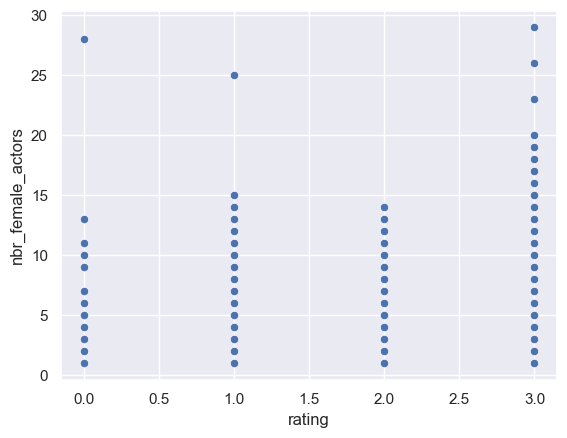

In [12]:
#We will here do a scatterplot between the bechdel test score and the number of female acotrs in each movie

sns.scatterplot(data=df_mb, y='nbr_female_actors',x='rating')

valid_data = df_mb[df_mb['nbr_female_actors'].notna()]

correlation, p_value = stats.pearsonr(valid_data['nbr_female_actors'], valid_data['rating'])

print(f"Pearson correlation: {correlation}, p-value: {p_value}")

correlation, p_value = stats.spearmanr(valid_data['nbr_female_actors'], valid_data['rating'])

print(f"Spearman correlation: {correlation}, p-value: {p_value}")

primary_genre
Thriller                          1189
Drama                              619
Crime Fiction                      433
Romantic comedy                    417
Science Fiction                    205
                                  ... 
Media Studies                        1
Nature                               1
Sci Fi Pictures original films       1
Slice of life story                  1
Concert film                         1
Name: count, Length: 169, dtype: int64

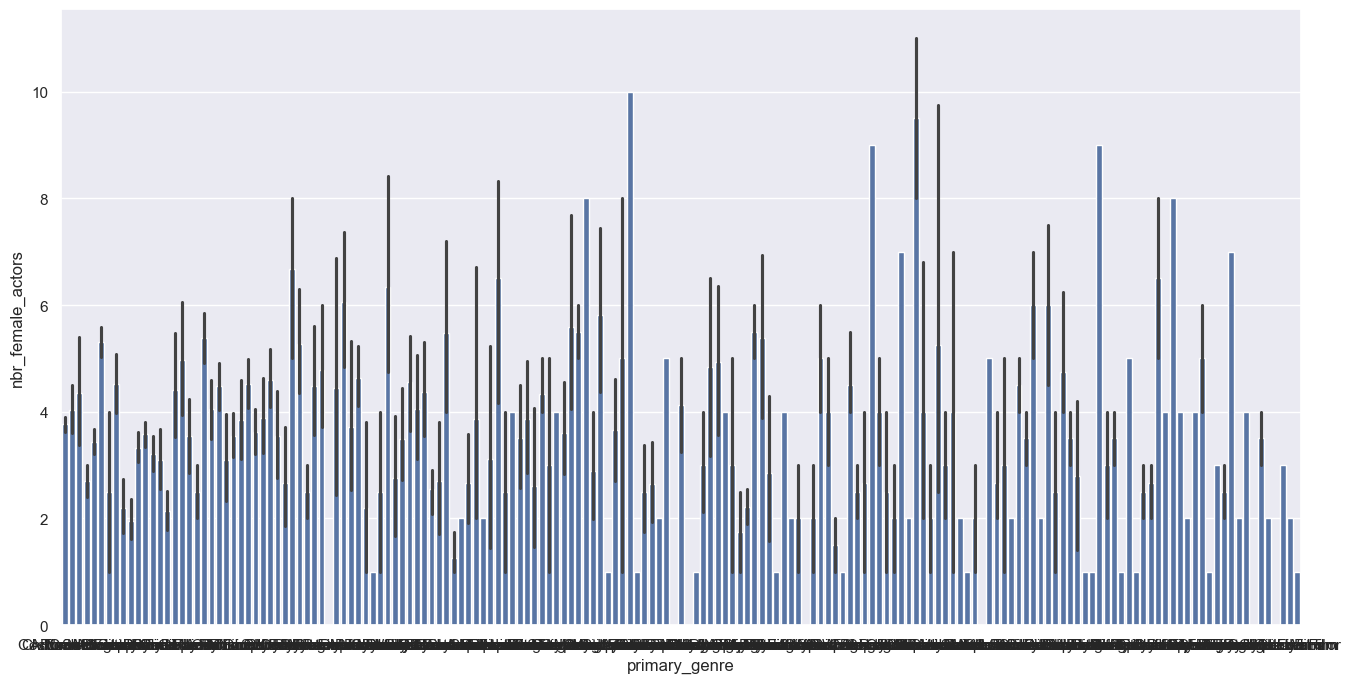

In [13]:
#We will here do a scatterplot between the bechdel test score and the number of female actors in each movie

def get_primary_genre(genre_list):
    try:
        genre_dict=json.loads(genre_list)

        if not genre_dict:
            return None

        primary_genre = list(genre_dict.values())[0]
        return primary_genre
    except KeyError or IndexError:
        return None


df_mb['primary_genre'] = df_mb['genre'].apply(get_primary_genre)

plt.figure(figsize=(16, 8))
sns.barplot(data=df_mb, y='nbr_female_actors',x='primary_genre')

df_mb['primary_genre'].value_counts()
